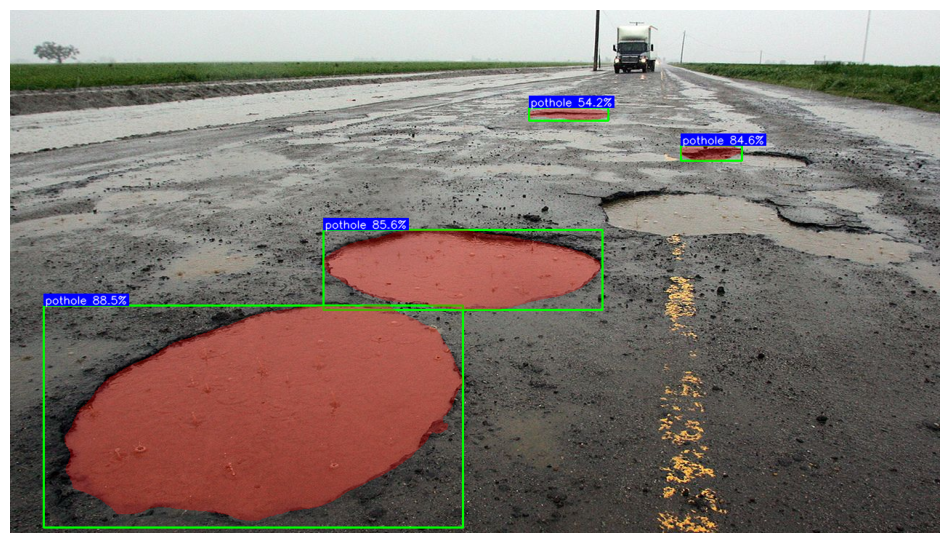

In [22]:
from inference_sdk import InferenceHTTPClient
import supervision as sv
import cv2
CLIENT = InferenceHTTPClient(
    api_url="https://serverless.roboflow.com",
    api_key="ug2qlXusJiZoRmRSug6C"
)

# model_id here is ONLY project/version
image_file = "/Users/pawankalyanreddy/Projects/ML_Notebooks/Pothole-1/test/Potholes_GaryKazanjian_AP-060403020716.jpeg"
img = cv2.imread(image_file)
result = CLIENT.infer(image_file,
    model_id="pothole-abpqz-rd1if/2",   # ← no workspace, no -rd1if
)
detections = sv.Detections.from_inference(result)
detections = detections[detections.confidence>0.15]

labels = [f"pothole {conf*100:.1f}%" for conf in detections.confidence]

bounding_box_annotator = sv.BoxAnnotator(sv.Color.GREEN, thickness=2) 
mask_annotator = sv.MaskAnnotator(sv.Color.RED, opacity=0.3,)
label_annotator = sv.LabelAnnotator(sv.Color.BLUE, text_scale= 0.5, text_color = sv.Color.WHITE, text_position=sv.Position.TOP_LEFT, text_padding=2 )



annotated_image = bounding_box_annotator.annotate(scene = img, detections = detections)
annotated_image = mask_annotator.annotate(scene = annotated_image, detections = detections)
annotated_image = label_annotator.annotate(scene = annotated_image, detections = detections, labels = labels)
sv.plot_image(annotated_image)

In [50]:
%pip install roboflow

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 86 kB 2.3 MB/s eta 0:00:011
     |████████████████████████████████| 2.8 MB 9.3 MB/s eta 0:00:01
     |████████████████████████████████| 66 kB 11.0 MB/s eta 0:00:01
     |████████████████████████████████| 54.8 MB 3.0 MB/s eta 0:00:012
     |████████████████████████████████| 2.2 MB 7.8 MB/s eta 0:00:01
  Attempting uninstall: idna
    Found existing installation: idna 3.10
    Uninstalling idna-3.10:
      Successfully uninstalled idna-3.10
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [23]:
import numpy as np
import supervision as sv
from inference.models.utils import get_roboflow_model

model = get_roboflow_model(model_id="pothole-abpqz-rd1if/2", api_key="ug2qlXusJiZoRmRSug6C")
tracker = sv.ByteTrack()

def callback(frame: np.ndarray, _: int) -> np.ndarray:

    height, width, channels = frame.shape
    image_area = height * width

    results = model.infer(frame)[0]
    detections = sv.Detections.from_inference(results)
    detections = tracker.update_with_detections(detections)
    detections = detections[detections.confidence>0.15]
    detections = detections[(detections.area/image_area)<0.4]

    labels = [f"pothole {conf*100:.1f}%"
                for conf in  detections.confidence]
                
    bounding_box_annotator = sv.BoxAnnotator(sv.Color.GREEN, thickness=2) 
    mask_annotator = sv.MaskAnnotator(sv.Color.RED, opacity=0.3,)
    label_annotator = sv.LabelAnnotator(sv.Color.BLUE, text_scale= 0.3, text_color = sv.Color.WHITE, text_position=sv.Position.TOP_LEFT, text_padding=2)



    annotated_image = bounding_box_annotator.annotate(scene = frame.copy(), detections = detections)
    annotated_image = mask_annotator.annotate(scene = annotated_image, detections = detections)
    annotated_image = label_annotator.annotate(scene = annotated_image, detections = detections, labels = labels)
        
    return annotated_image

sv.process_video(
    source_path="/Users/pawankalyanreddy/Projects/ML_Notebooks/Pothole-1/mixkit-potholes-in-a-rural-road-25208-hd-ready.mp4",
    target_path="output.mp4",
    callback=callback
)

